In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

from matplotlib import font_manager
f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family = 'Arial Unicode MS')

In [2]:
# 데이터 가지고오기
socar_df = pd.read_csv("../../0. raw_data/insurance_fraud_detect_data.csv")
pd.set_option('display.max_columns', len(socar_df.columns))
socar_df.head()

fraud_YN  car_model  sharing_type  age_group  has_previous_accident  \
0         0          2             1          3                      0   
1         0          1             0          4                      0   
2         0          1             0          4                      1   
3         0          3             1          3                      0   
4         0          1             0          1                      0   

   cumulative_use_count  b2b  accident_ratio  pf_type  socarpass  socarsave  \
0                     2    0             100        2          0          0   
1                     4    0               0        3          1          0   
2                     4    0             100        3          1          0   
3                     4    0               0        2          0          0   
4                     1    0             100        1          0          0   

   start_hour  duration  accident_hour   repair_cost  insure_cost  \
0           4         2              4  1.302547e+05            0   
1           1         4              4  0.000000e+00            0   
2           1         4              6  2.581306e+05     12925040   
3           3         3              5  1.341009e+06            0   
4           1         1              1  5.240306e+05      1209410   

   accident_location  car_part1  car_part2  repair_cnt  acc_type1  \
0                  1          0          0           1          0   
1                  1          1          1           2          1   
2                  3          1          0           2          1   
3                  3          1          0           1          0   
4                  1          0          0           2          0   

   insurance_site_aid_YN  police_site_aid_YN  total_prsn_cnt  test_set  
0                      0                   0              -1         0  
1                      1                   1               0         1  
2                      1                   1               0         1  
3                      0                   0              -1         0  
4                      0                   0              -1         0

In [3]:
# column 확인
socar_df.columns

Index(['fraud_YN', 'car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
       'accident_ratio', 'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN',
       'total_prsn_cnt', 'test_set'],
      dtype='object')

In [4]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_df[socar_df.test_set == 0]
final_test_df = socar_df[socar_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [25]:
# 나중에 test 세트를 예측해야 하니까 test 세트도 변수에 넣어줌.
# final 붙은 data는 최종 성능 점검에서만 사용 !
X_final_test = final_test_df.iloc[:, 1:]
y_final_test = final_test_df.iloc[:, 0]

In [26]:
# 학습해야 할 train 세트 - 타겟변수와 피쳐 분리
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

X.shape, y.shape

((12879, 23), (12879,))

### 1. Original Data

In [7]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [8]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1]), array([8991,   24]))

In [9]:
tmp = np.unique(y_train, return_counts=True)[1]
tmp[1]/len(y_train) *100

0.26622296173044924

In [10]:
tmp = np.unique(y_test, return_counts=True)[1]
tmp[1]/len(y_test) *100

0.2587991718426501

In [11]:
# 성능지표 반환 함수 생성
from sklearn.metrics import(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc

In [12]:
# confusion_matrix 생성함수
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    return confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]

In [13]:
# 모델과 데이터를 주면 confusion matrix를 출력하는 함수
def get_confusion(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)    
    return print_clf_eval(y_test, pred)

In [14]:
# 다수의 모델 confusin matrix 정리해서 DataFrame으로 반환
def get_confusion_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['f0p0', 'fo0p1', 'f1p0', 'f1p1']
    tmp =[]
    
    for model in models:
        tmp.append(get_confusion(model, X_train, y_train, X_test, y_test))
    
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

### 분류모델 
- 1. Logistic Regression
- 2. Decision Tree
- 3. Random Forest
- 4. LightGBM

In [15]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

(3854, 0, 10, 0)

In [16]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=2)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

(3854, 0, 10, 0)

In [17]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=1, n_estimators=300)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

(3854, 0, 10, 0)

In [18]:
# lgbm
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred= lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

(3853, 1, 10, 0)

In [19]:
# svm
from sklearn import svm

svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
svm_pred= svm_clf.predict(X_test)

print_clf_eval(y_test, svm_pred)

(3854, 0, 10, 0)

In [20]:
# 모델과 데이터를 주면 성능을 출력하는 함수 
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return get_clf_eval(y_test, pred)

In [21]:
# 다수의 모델 성능을 정리해서 DataFrame으로 반환
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp =[]
    
    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [52]:
# 4개의 분류모델 표로 정리
import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train, y_train, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  4.75342583656311


accuracy  precision  recall   f1  roc_auc  f0p0  fo0p1  f1p0  \
LogisticReg   0.997412        0.0     0.0  0.0  0.50000  3854      0    10   
DecisionTree  0.997412        0.0     0.0  0.0  0.50000  3854      0    10   
RandomForest  0.997412        0.0     0.0  0.0  0.50000  3854      0    10   
LightGBM      0.997153        0.0     0.0  0.0  0.49987  3853      1    10   

              f1p1  
LogisticReg      0  
DecisionTree     0  
RandomForest     0  
LightGBM         0

In [53]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  11.444859027862549


accuracy  precision  recall       f1   roc_auc  f0p0  fo0p1  \
LogisticReg   0.187371   0.002543     0.8  0.00507  0.492891   716   3138   
DecisionTree  0.802536   0.000000     0.0  0.00000  0.402309  3101    753   
RandomForest  0.994824   0.000000     0.0  0.00000  0.498703  3844     10   
LightGBM      0.993530   0.000000     0.0  0.00000  0.498054  3839     15   

              f1p0  f1p1  
LogisticReg      2     8  
DecisionTree    10     0  
RandomForest    10     0  
LightGBM        10     0

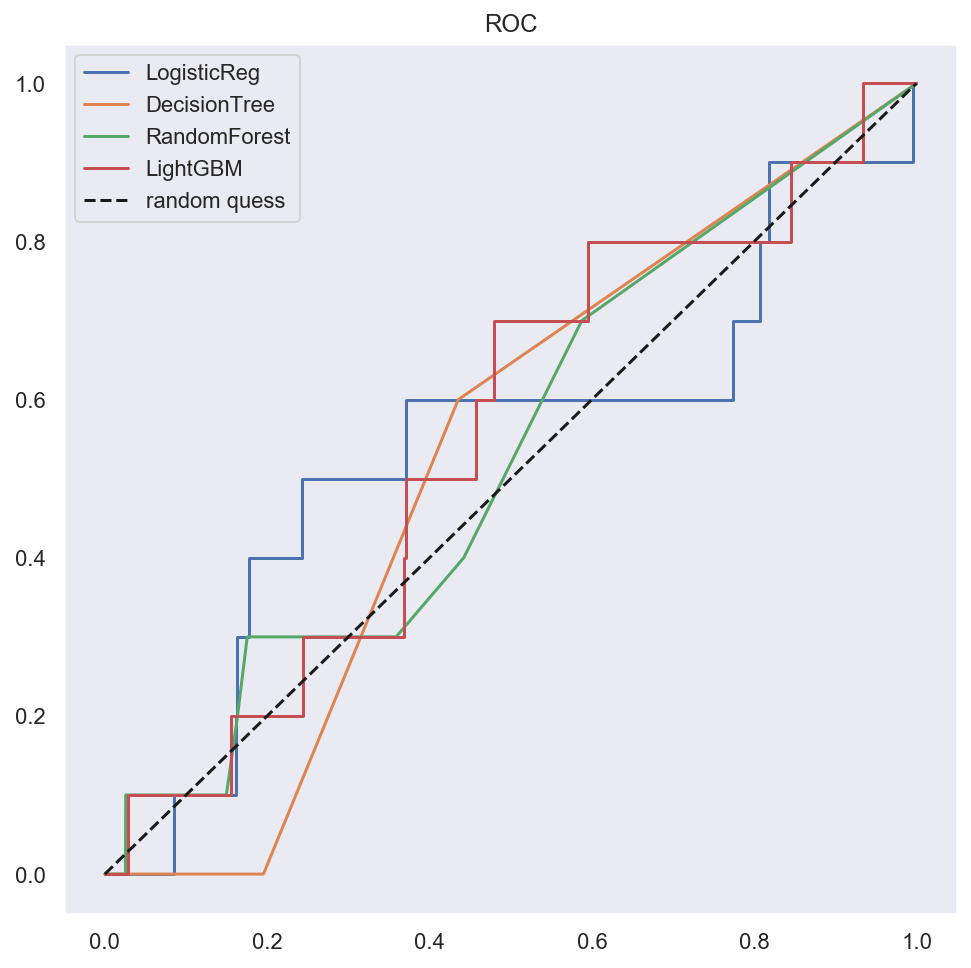

In [45]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 2. StandardScale to sequential features

''

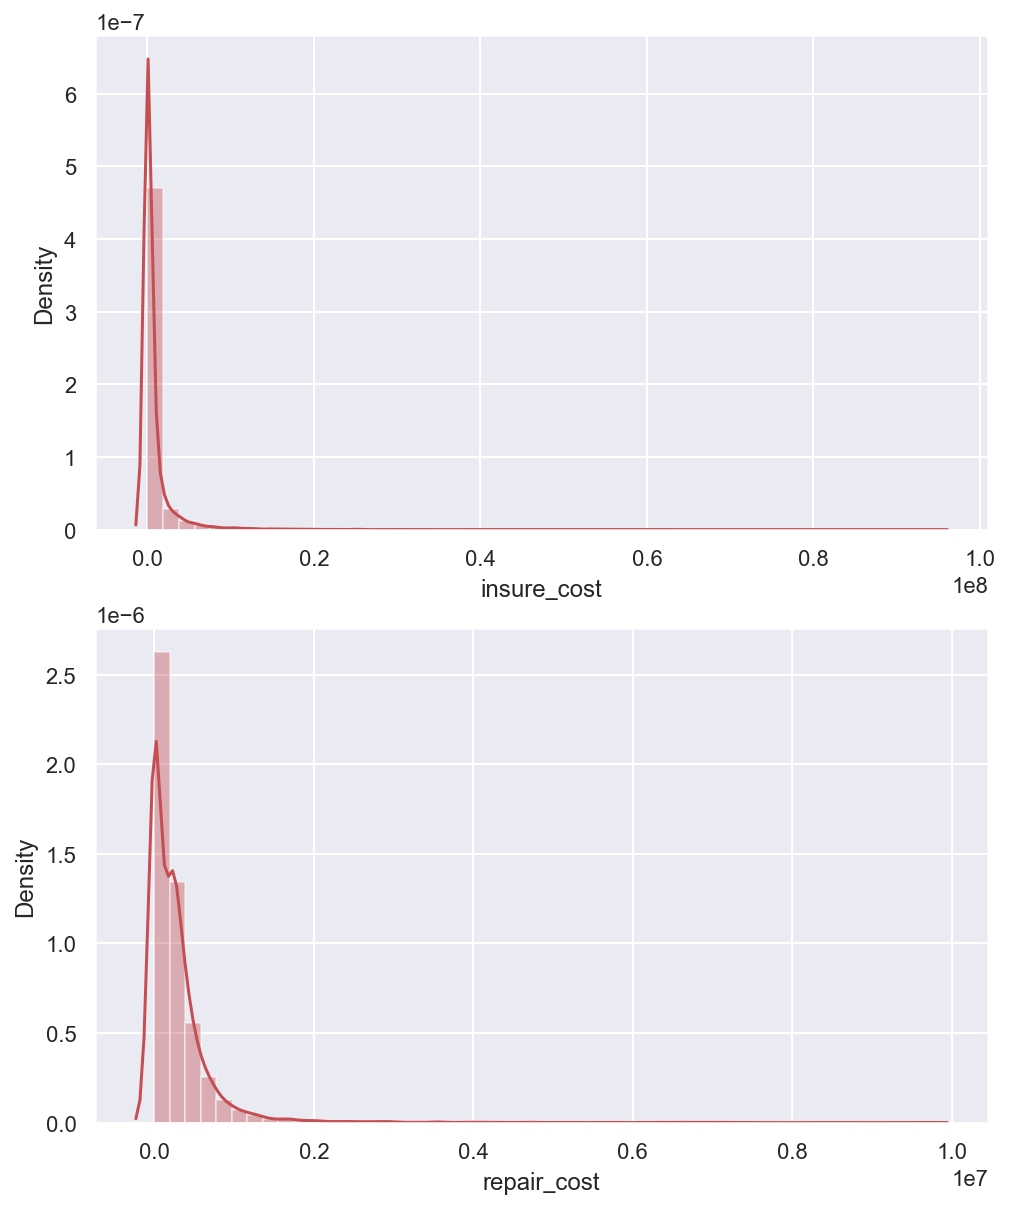

In [76]:
# 연속형 변수는 2개, 분포를 확인해보자
f, ax = plt.subplots(2, 1, figsize = (8, 10))

sns.distplot(train_df["insure_cost"], color="r", ax = ax[0])
sns.distplot(train_df["repair_cost"], color="r", ax = ax[1])
;
# 한쪽으로 매우 치우쳐져있다 -> 표준화

In [77]:
# train_df 에서 연속형 변수 가져와서 scaled feature 만들고
# target feature 및 original 연속형변수 삭제
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
insure_n = scaler.fit_transform(train_df['insure_cost'].values.reshape(-1,1))
repair_n = scaler.fit_transform(train_df['repair_cost'].values.reshape(-1,1))

X_ss = train_df.drop(['fraud_YN', 'insure_cost', 'repair_cost'], axis=1) 
X_ss['scaled_insure_cost'] = insure_n
X_ss['scaled_repair_cost'] = repair_n

X_ss.head()

car_model  sharing_type  age_group  has_previous_accident  \
0          2             1          3                      0   
1          3             1          3                      0   
2          1             0          1                      0   
3          1             1          3                      0   
4          2             0          4                      0   

   cumulative_use_count  b2b  accident_ratio  pf_type  socarpass  socarsave  \
0                     2    0             100        2          0          0   
1                     4    0               0        2          0          0   
2                     1    0             100        1          0          0   
3                     4    0             100        3          0          0   
4                     4    0               0        1          0          0   

   start_hour  duration  accident_hour  accident_location  car_part1  \
0           4         2              4                  1          0   
1           3         3              5                  3          1   
2           1         1              1                  1          0   
3           6         3              1                  0          0   
4           4         2              6                  1          0   

   car_part2  repair_cnt  acc_type1  insurance_site_aid_YN  \
0          0           1          0                      0   
1          0           1          0                      0   
2          0           2          0                      0   
3          0           1          1                      2   
4          0           1          1                      1   

   police_site_aid_YN  total_prsn_cnt  scaled_insure_cost  scaled_repair_cost  
0                   0              -1           -0.273447           -0.296588  
1                   0              -1           -0.273447            2.047627  
2                   0              -1            0.121310            0.465826  
3                   1               2            0.123879           -0.548781  
4                   1               2           -0.273447           -0.548781

In [78]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, test_size=0.3, random_state=13, stratify=y)

In [293]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  2.1320247650146484


accuracy  precision  recall   f1  roc_auc
LogisticReg   0.997412        0.0     0.0  0.0      0.5
DecisionTree  0.997412        0.0     0.0  0.0      0.5
RandomForest  0.997412        0.0     0.0  0.0      0.5
LightGBM      0.997412        0.0     0.0  0.0      0.5

In [79]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  9.918358087539673


accuracy  precision  recall        f1   roc_auc  f0p0  fo0p1  \
LogisticReg   0.766822   0.001120     0.1  0.002215  0.434276  2962    892   
DecisionTree  0.601190   0.003245     0.5  0.006447  0.550727  2318   1536   
RandomForest  0.996377   0.000000     0.0  0.000000  0.499481  3850      4   
LightGBM      0.993271   0.000000     0.0  0.000000  0.497924  3838     16   

              f1p0  f1p1  
LogisticReg      9     1  
DecisionTree     5     5  
RandomForest    10     0  
LightGBM        10     0

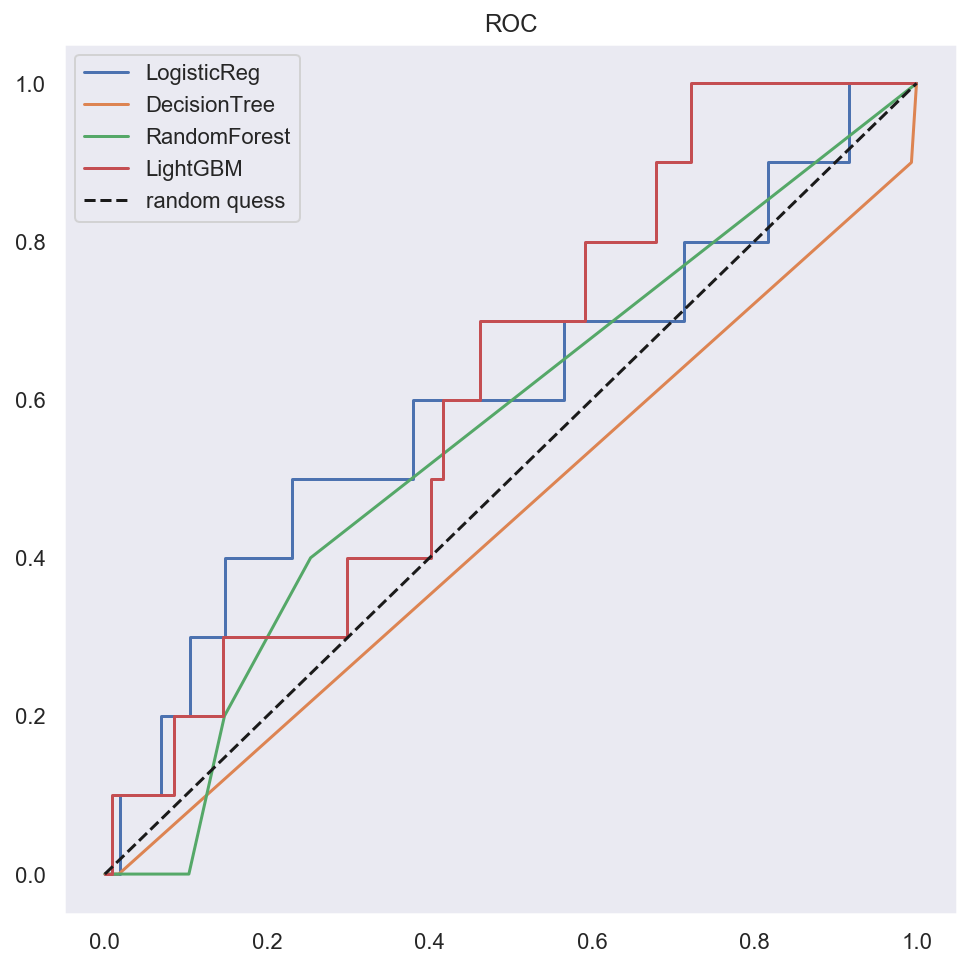

In [294]:
from sklearn.
metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 3. log scale

In [80]:
insure_log = np.log1p(train_df['insure_cost'])
repair_log = np.log1p(train_df['repair_cost'])

X_ls= train_df.drop(['insure_cost', 'repair_cost', 'fraud_YN'], axis=1) 
X_ls['scaled_insure_cost'] = insure_log
X_ls['scaled_repair_cost'] = repair_log

X_ls.head()

car_model  sharing_type  age_group  has_previous_accident  \
0          2             1          3                      0   
1          3             1          3                      0   
2          1             0          1                      0   
3          1             1          3                      0   
4          2             0          4                      0   

   cumulative_use_count  b2b  accident_ratio  pf_type  socarpass  socarsave  \
0                     2    0             100        2          0          0   
1                     4    0               0        2          0          0   
2                     1    0             100        1          0          0   
3                     4    0             100        3          0          0   
4                     4    0               0        1          0          0   

   start_hour  duration  accident_hour  accident_location  car_part1  \
0           4         2              4                  1          0   
1           3         3              5                  3          1   
2           1         1              1                  1          0   
3           6         3              1                  0          0   
4           4         2              6                  1          0   

   car_part2  repair_cnt  acc_type1  insurance_site_aid_YN  \
0          0           1          0                      0   
1          0           1          0                      0   
2          0           2          0                      0   
3          0           1          1                      2   
4          0           1          1                      1   

   police_site_aid_YN  total_prsn_cnt  scaled_insure_cost  scaled_repair_cost  
0                   0              -1            0.000000           11.777255  
1                   0              -1            0.000000           14.108934  
2                   0              -1           14.005644           13.169307  
3                   1               2           14.012130            0.000000  
4                   1               2            0.000000            0.000000

In [81]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ls, y, test_size=0.3, random_state=13, stratify=y)

In [297]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

# standard scale과 성능이 똑같아서 roc auc 안그림

Fit time:  2.2067761421203613


accuracy  precision  recall   f1  roc_auc
LogisticReg   0.997412        0.0     0.0  0.0      0.5
DecisionTree  0.997412        0.0     0.0  0.0      0.5
RandomForest  0.997412        0.0     0.0  0.0      0.5
LightGBM      0.997412        0.0     0.0  0.0      0.5

In [82]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  10.842713117599487


accuracy  precision  recall        f1   roc_auc  f0p0  fo0p1  \
LogisticReg   0.795031   0.001276     0.1  0.002519  0.448417  3071    783   
DecisionTree  0.802536   0.000000     0.0  0.000000  0.402309  3101    753   
RandomForest  0.995083   0.000000     0.0  0.000000  0.498832  3845      9   
LightGBM      0.992236   0.000000     0.0  0.000000  0.497405  3834     20   

              f1p0  f1p1  
LogisticReg      9     1  
DecisionTree    10     0  
RandomForest    10     0  
LightGBM        10     0

### 4. remove outlier

In [83]:
# 사기 데이터라 비용이 fraud가 이상치에서 발생했나 보려고 fraud YN 에 따라 plot 따로 그려봄
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==0]['insure_cost'], name = 'insure_cost_0'))
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==1]['insure_cost'], name = 'insure_cost_1'))

fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==0]['repair_cost'], name = 'repair_cost_0'))
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==1]['repair_cost'], name = 'repair_cost_1'))

# 이상치가 fraud data에 영향을 끼칠것 같지는 않음

In [84]:
# 이상치 제거하는 함수 생성

def get_outlier(df=None, column=None, weight=1.5):
    fraud= df[df["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [85]:
# insure_cost에서는 최대치를 벗어나는 값이 3개 있었음
get_outlier(df=train_df, column="insure_cost", weight=1.5)

Int64Index([92, 342, 3773], dtype='int64')

In [86]:
# repair_cost에서는 최대치를 벗어나는 값이 2개 있었음
get_outlier(df=train_df, column="repair_cost", weight=1.5)

Int64Index([12, 4576], dtype='int64')

In [87]:
# 이상치 제거, 중복 index 있으면 unique하게 남겨두기
outlier_index = list(get_outlier(df=train_df, column="insure_cost", weight=1.5)) + list(get_outlier(df=train_df, column="repair_cost", weight=1.5))
outlier_index = set(outlier_index)

# origianl data 이상치 제거 
X_rmol = X.drop(outlier_index, axis=0)

# standard scaled data 이상치 제거 
X_ss_rmol = X_ss.drop(outlier_index, axis=0)

# log scaled data 이상치 제거
X_ls_rmol = X_ls.drop(outlier_index, axis=0)

# target 변수 이상치 제거 
y_rmol = y.drop(outlier_index, axis=0)

In [88]:
X_rmol.shape, X_ss_rmol.shape, X_ls_rmol.shape, y_rmol.shape

((12874, 23), (12874, 23), (12874, 23), (12874,))

In [89]:
# original 이상치 제거
X_train, X_test, y_train, y_test = train_test_split(X_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  2.3968799114227295


accuracy  precision  recall   f1  roc_auc
LogisticReg    0.99767        0.0     0.0  0.0      0.5
DecisionTree   0.99767        0.0     0.0  0.0      0.5
RandomForest   0.99767        0.0     0.0  0.0      0.5
LightGBM       0.99767        0.0     0.0  0.0      0.5

In [90]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  10.813306093215942


accuracy  precision    recall        f1   roc_auc  f0p0  fo0p1  \
LogisticReg   0.719907   0.001857  0.222222  0.003683  0.471646  2779   1075   
DecisionTree  0.997670   0.000000  0.000000  0.000000  0.500000  3854      0   
RandomForest  0.995858   0.000000  0.000000  0.000000  0.499092  3847      7   
LightGBM      0.995599   0.000000  0.000000  0.000000  0.498962  3846      8   

              f1p0  f1p1  
LogisticReg      7     2  
DecisionTree     9     0  
RandomForest     9     0  
LightGBM         9     0

In [91]:
# standard scale 이상치 제거
X_train, X_test, y_train, y_test = train_test_split(X_ss_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)


In [441]:

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  1.960726022720337


accuracy  precision  recall   f1  roc_auc
LogisticReg    0.99767        0.0     0.0  0.0      0.5
DecisionTree   0.99767        0.0     0.0  0.0      0.5
RandomForest   0.99767        0.0     0.0  0.0      0.5
LightGBM       0.99767        0.0     0.0  0.0      0.5

In [92]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  11.314616203308105


accuracy  precision    recall        f1   roc_auc  f0p0  fo0p1  \
LogisticReg   0.762102   0.001096  0.111111  0.002172  0.437367  2943    911   
DecisionTree  0.758996   0.003233  0.333333  0.006403  0.546661  2929    925   
RandomForest  0.996376   0.000000  0.000000  0.000000  0.499351  3849      5   
LightGBM      0.994823   0.000000  0.000000  0.000000  0.498573  3843     11   

              f1p0  f1p1  
LogisticReg      8     1  
DecisionTree     6     3  
RandomForest     9     0  
LightGBM         9     0

In [93]:
# log scale 이상치 제거
X_train, X_test, y_train, y_test = train_test_split(X_ls_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)


In [ ]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

In [94]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  11.099042892456055


accuracy  precision    recall        f1   roc_auc  f0p0  fo0p1  \
LogisticReg   0.777634   0.001174  0.111111  0.002323  0.445151  3003    851   
DecisionTree  0.758996   0.003233  0.333333  0.006403  0.546661  2929    925   
RandomForest  0.996376   0.000000  0.000000  0.000000  0.499351  3849      5   
LightGBM      0.996117   0.000000  0.000000  0.000000  0.499222  3848      6   

              f1p0  f1p1  
LogisticReg      8     1  
DecisionTree     6     3  
RandomForest     9     0  
LightGBM         9     0

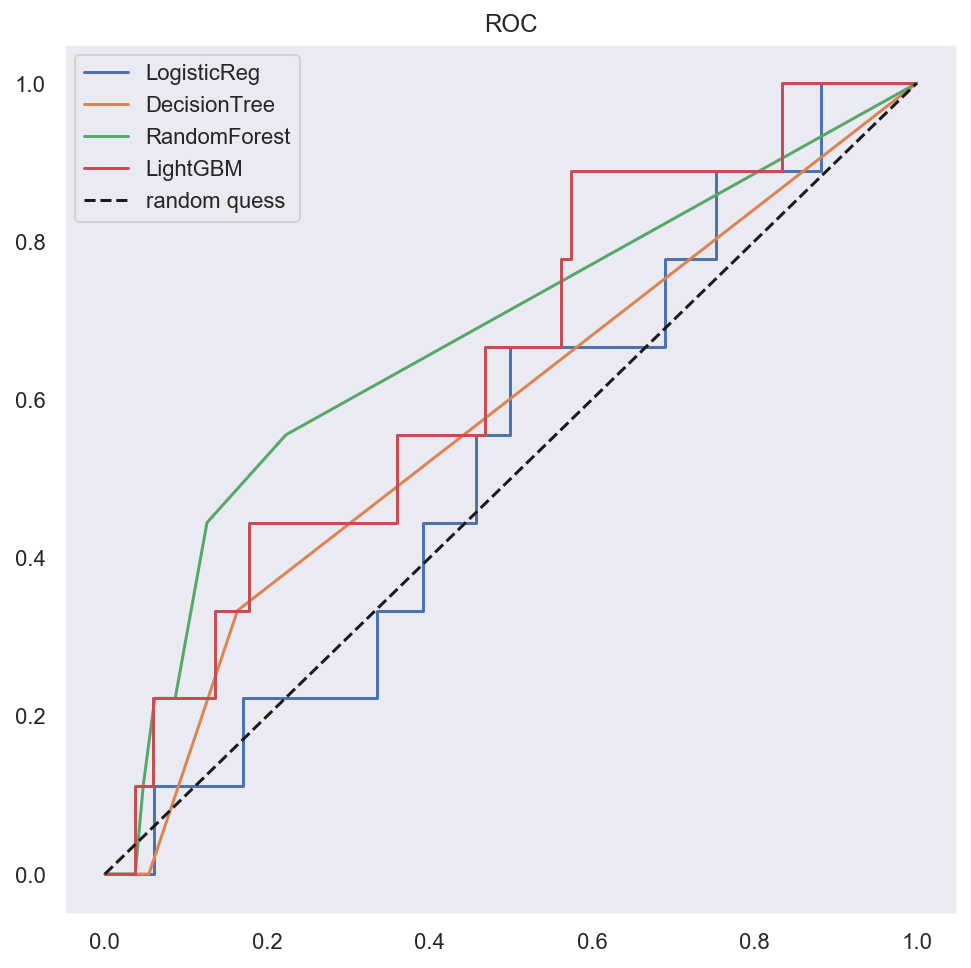

In [443]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

In [338]:
########## final test data 적용 ##############

In [446]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_over, return_counts=True))

(array([0, 1]), array([8991,   20]))
(array([0, 1]), array([8991, 8991]))


In [447]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  4.647290229797363


accuracy  precision    recall        f1   roc_auc
LogisticReg   0.747864   0.002064  0.222222  0.004090  0.485657
DecisionTree  0.827077   0.004511  0.333333  0.008902  0.580782
RandomForest  0.996376   0.000000  0.000000  0.000000  0.499351
LightGBM      0.996117   0.000000  0.000000  0.000000  0.499222

In [448]:
# 4개의 분류모델 표로 정리
import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  5.183608055114746


accuracy  precision    recall        f1   roc_auc
LogisticReg   0.747864   0.002064  0.222222  0.004090  0.485657
DecisionTree  0.827077   0.004511  0.333333  0.008902  0.580782
RandomForest  0.996376   0.000000  0.000000  0.000000  0.499351
LightGBM      0.996117   0.000000  0.000000  0.000000  0.499222

In [21]:
# 1. standard scaling

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
insure_n = scaler.fit_transform(socar_rm_ol['insure_cost'].values.reshape(-1,1))
repair_n = scaler.fit_transform(socar_rm_ol['repair_cost'].values.reshape(-1,1))

socar_ss_df = socar_rm_ol.drop(['insure_cost', 'repair_cost'], axis=1) 
socar_ss_df['scaled_insure_cost'] = insure_n
socar_ss_df['scaled_repair_cost'] = repair_n
socar_ss_df.tail()

fraud_YN  car_model  sharing_type  age_group  has_previous_accident  \
15995         0          2             0          2                      0   
15996         0          2             0          2                      1   
15997         0          2             1          2                      0   
15998         0          2             0          2                      0   
15999         0          2             0          2                      0   

       cumulative_use_count  b2b  accident_ratio  pf_type  socarpass  \
15995                     2    0             100        2          0   
15996                     4    0             100        1          1   
15997                     4    0             100        1          0   
15998                     2    0             100        2          0   
15999                     1    0             100        1          0   

       socarsave  start_hour  duration  accident_hour  accident_location  \
15995          0           1         1              1                  1   
15996          0           5         2              6                  2   
15997          0           1         3              5                  0   
15998          0           6         1              2                  4   
15999          0           6         5              6                  2   

       car_part1  car_part2  repair_cnt  acc_type1  insurance_site_aid_YN  \
15995          1          0           1          0                      0   
15996          1          0           1          0                      0   
15997          0          0           1          0                      0   
15998          1          0           1          0                      0   
15999          0          0           1          0                      0   

       police_site_aid_YN  total_prsn_cnt  test_set  scaled_insure_cost  \
15995                   0              -1         0           -0.277444   
15996                   0              -1         0           -0.277444   
15997                   0              -1         1           -0.277444   
15998                   0              -1         0           -0.277444   
15999                   0              -1         0            0.106978   

       scaled_repair_cost  
15995           -0.551438  
15996            0.646717  
15997           -0.551438  
15998           -0.551438  
15999            0.207165

In [97]:
# log scale
insure_log = np.log1p(socar_rm_ol['insure_cost'])
repair_log = np.log1p(socar_rm_ol['repair_cost'])

socar_ls_df= socar_rm_ol.drop(['insure_cost', 'repair_cost'], axis=1) 
socar_ls_df['scaled_insure_cost'] = insure_log
socar_ls_df['scaled_repair_cost'] = repair_log

socar_ls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15995 entries, 0 to 15999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               15995 non-null  int64  
 1   car_model              15995 non-null  int64  
 2   sharing_type           15995 non-null  int64  
 3   age_group              15995 non-null  int64  
 4   has_previous_accident  15995 non-null  int64  
 5   cumulative_use_count   15995 non-null  int64  
 6   b2b                    15995 non-null  int64  
 7   accident_ratio         15995 non-null  int64  
 8   pf_type                15995 non-null  int64  
 9   socarpass              15995 non-null  int64  
 10  socarsave              15995 non-null  int64  
 11  start_hour             15995 non-null  int64  
 12  duration               15995 non-null  int64  
 13  accident_hour          15995 non-null  int64  
 14  accident_location      15995 non-null  int64  
 15  ca

In [100]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_ls_df[socar_ls_df.test_set == 0]
final_test_df = socar_ls_df[socar_ls_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)
final_test_df.tail()

fraud_YN  car_model  sharing_type  age_group  has_previous_accident  \
3116         0          1             0          2                      0   
3117         0          2             0          1                      0   
3118         0          2             0          2                      0   
3119         0          2             0          2                      0   
3120         0          2             1          2                      0   

      cumulative_use_count  b2b  accident_ratio  pf_type  socarpass  \
3116                     4    0             100        3          0   
3117                     4    0             100        3          0   
3118                     1    0             100        1          0   
3119                     2    0             100        3          0   
3120                     4    0             100        1          0   

      socarsave  start_hour  duration  accident_hour  accident_location  \
3116          0           5         1              6                  0   
3117          0           6         1              6                  4   
3118          0           6         2              2                  0   
3119          0           1         3              1                  4   
3120          0           1         3              5                  0   

      car_part1  car_part2  repair_cnt  acc_type1  insurance_site_aid_YN  \
3116          0          0           1          1                      1   
3117          1          0           1          0                      0   
3118          0          0           1          1                      1   
3119          0          0           2          0                      0   
3120          0          0           1          0                      0   

      police_site_aid_YN  total_prsn_cnt  scaled_insure_cost  \
3116                   1               1           14.351256   
3117                   0              -1            0.000000   
3118                   1               1           13.605075   
3119                   0              -1            0.000000   
3120                   0              -1            0.000000   

      scaled_repair_cost  
3116            0.000000  
3117            0.000000  
3118           12.765259  
3119           13.898332  
3120            0.000000

In [101]:
# 나중에 test 세트를 예측해야 하니까 test 세트도 변수에 넣어줌.
# final 붙은 data는 최종 성능 점검에서만 사용 !
X_final_test = final_test_df.drop(columns=["fraud_YN"])
y_final_test = final_test_df["fraud_YN"]
y_final_test.tail()

3116    0
3117    0
3118    0
3119    0
3120    0
Name: fraud_YN, dtype: int64

In [102]:
# 학습해야 할 train 세트 - 타겟변수와 피쳐 분리
X = train_df.drop(columns=["fraud_YN"])
y = train_df["fraud_YN"]

X.shape, y.shape

((12874, 23), (12874,))

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X, y)

X_train_over.shape, y_train_over.shape, X.shape, y.shape

((25690, 23), (25690,), (12879, 23), (12879,))

In [23]:
print(np.unique(y_train_over, return_counts=True))
print(np.unique(y, return_counts=True))

(array([0, 1]), array([12845, 12845]))
(array([0, 1]), array([12845,    34]))


In [27]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  77.64639091491699


accuracy  precision    recall       f1   roc_auc  f0p0  fo0p1  \
LogisticReg   0.746876    0.00000  0.000000  0.00000  0.374277  2331    783   
DecisionTree  0.997116    0.00000  0.000000  0.00000  0.499679  3112      2   
RandomForest  0.996796    0.00000  0.000000  0.00000  0.499518  3111      3   
LightGBM      0.991669    0.00000  0.000000  0.00000  0.496949  3095     19   
SVM           0.758090    0.00266  0.285714  0.00527  0.522433  2364    750   

              f1p0  f1p1  
LogisticReg      7     0  
DecisionTree     7     0  
RandomForest     7     0  
LightGBM         7     0  
SVM              5     2

In [79]:
# train set 에서 타겟변수의 이상치 제거
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['test_set']==0]
    fraud = fraud[fraud["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [80]:
# 이상치 제거, 중복 index 있으면 unique하게 남겨두기
outlier_index = list(get_outlier(df=socar_df, column="insure_cost", weight=1.5)) + list(get_outlier(df=socar_df, column="repair_cost", weight=1.5))
outlier_index = set(outlier_index)

# raw_data에서 이상치부터 제거
socar_rm_ol = socar_df.drop(outlier_index, axis=0)
socar_rm_ol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15995 entries, 0 to 15999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               15995 non-null  int64  
 1   car_model              15995 non-null  int64  
 2   sharing_type           15995 non-null  int64  
 3   age_group              15995 non-null  int64  
 4   has_previous_accident  15995 non-null  int64  
 5   cumulative_use_count   15995 non-null  int64  
 6   b2b                    15995 non-null  int64  
 7   accident_ratio         15995 non-null  int64  
 8   pf_type                15995 non-null  int64  
 9   socarpass              15995 non-null  int64  
 10  socarsave              15995 non-null  int64  
 11  start_hour             15995 non-null  int64  
 12  duration               15995 non-null  int64  
 13  accident_hour          15995 non-null  int64  
 14  repair_cost            15995 non-null  float64
 15  in